In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b10','b25','b50','b75'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b10_b25_b50_b75_t1_mask_t1t2_normalized_k5_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 460)
(734160, 1)
validation
(101248, 460)
(101248, 1)
test
(100432, 460)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 460)]             0         


 dense (Dense)               (None, 1024)              472064    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1161217 (4.43 MB)


Trainable params: 1161217 (4.43 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:23 - loss: 0.2022 - STD: 6.1403e-05 - MAE: 0.4365

 5/74 [=>............................] - ETA: 10s - loss: 0.0678 - STD: 1.3725e-04 - MAE: 0.1930 

 9/74 [==>...........................] - ETA: 5s - loss: 0.0550 - STD: 9.3536e-05 - MAE: 0.1833 

13/74 [====>.........................] - ETA: 3s - loss: 0.0491 - STD: 6.9820e-05 - MAE: 0.1752

17/74 [=====>........................] - ETA: 2s - loss: 0.0418 - STD: 5.8222e-05 - MAE: 0.1550

21/74 [=======>......................] - ETA: 2s - loss: 0.0363 - STD: 5.2755e-05 - MAE: 0.1428

25/74 [=========>....................] - ETA: 1s - loss: 0.0333 - STD: 4.8760e-05 - MAE: 0.1390

29/74 [==========>...................] - ETA: 1s - loss: 0.0304 - STD: 4.5048e-05 - MAE: 0.1309

33/74 [============>.................] - ETA: 1s - loss: 0.0283 - STD: 4.1940e-05 - MAE: 0.1224

37/74 [==============>...............] - ETA: 1s - loss: 0.0267 - STD: 3.9501e-05 - MAE: 0.1157

41/74 [===============>..............] - ETA: 0s - loss: 0.0252 - STD: 3.7750e-05 - MAE: 0.1108

45/74 [=================>............] - ETA: 0s - loss: 0.0241 - STD: 3.6480e-05 - MAE: 0.1080

50/74 [===================>..........] - ETA: 0s - loss: 0.0229 - STD: 3.5293e-05 - MAE: 0.1052

54/74 [====================>.........] - ETA: 0s - loss: 0.0221 - STD: 3.4564e-05 - MAE: 0.1024

58/74 [======================>.......] - ETA: 0s - loss: 0.0214 - STD: 3.4101e-05 - MAE: 0.0997

62/74 [========================>.....] - ETA: 0s - loss: 0.0208 - STD: 3.3734e-05 - MAE: 0.0976

66/74 [=========================>....] - ETA: 0s - loss: 0.0203 - STD: 3.3573e-05 - MAE: 0.0961

70/74 [===========================>..] - ETA: 0s - loss: 0.0198 - STD: 3.3547e-05 - MAE: 0.0948

74/74 [==============================] - ETA: 0s - loss: 0.0194 - STD: 3.3630e-05 - MAE: 0.0934

74/74 [==============================] - 3s 29ms/step - loss: 0.0194 - STD: 3.3630e-05 - MAE: 0.0934 - val_loss: 0.0146 - val_STD: 2.8741e-05 - val_MAE: 0.0709


Epoch 2/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0117 - STD: 3.5653e-05 - MAE: 0.0662

 5/74 [=>............................] - ETA: 0s - loss: 0.0121 - STD: 3.7375e-05 - MAE: 0.0669

 9/74 [==>...........................] - ETA: 0s - loss: 0.0120 - STD: 3.8648e-05 - MAE: 0.0678

13/74 [====>.........................] - ETA: 0s - loss: 0.0120 - STD: 4.0038e-05 - MAE: 0.0687

17/74 [=====>........................] - ETA: 0s - loss: 0.0120 - STD: 4.1410e-05 - MAE: 0.0691

21/74 [=======>......................] - ETA: 0s - loss: 0.0120 - STD: 4.2803e-05 - MAE: 0.0690

25/74 [=========>....................] - ETA: 0s - loss: 0.0120 - STD: 4.4285e-05 - MAE: 0.0688

29/74 [==========>...................] - ETA: 0s - loss: 0.0120 - STD: 4.5724e-05 - MAE: 0.0689

34/74 [============>.................] - ETA: 0s - loss: 0.0120 - STD: 4.7601e-05 - MAE: 0.0690

38/74 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 4.9239e-05 - MAE: 0.0691

42/74 [================>.............] - ETA: 0s - loss: 0.0120 - STD: 5.1040e-05 - MAE: 0.0691

46/74 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 5.2820e-05 - MAE: 0.0691

50/74 [===================>..........] - ETA: 0s - loss: 0.0120 - STD: 5.4670e-05 - MAE: 0.0692

54/74 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 5.6579e-05 - MAE: 0.0692

58/74 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 5.8584e-05 - MAE: 0.0691

62/74 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 6.0585e-05 - MAE: 0.0691

66/74 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 6.2619e-05 - MAE: 0.0691

70/74 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 6.4878e-05 - MAE: 0.0691

74/74 [==============================] - 1s 15ms/step - loss: 0.0120 - STD: 6.7266e-05 - MAE: 0.0691 - val_loss: 0.0145 - val_STD: 9.6587e-05 - val_MAE: 0.0731


Epoch 3/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0114 - STD: 1.1420e-04 - MAE: 0.0676

 5/74 [=>............................] - ETA: 0s - loss: 0.0118 - STD: 1.1957e-04 - MAE: 0.0684

 9/74 [==>...........................] - ETA: 0s - loss: 0.0119 - STD: 1.2487e-04 - MAE: 0.0690

13/74 [====>.........................] - ETA: 0s - loss: 0.0119 - STD: 1.2959e-04 - MAE: 0.0691

17/74 [=====>........................] - ETA: 0s - loss: 0.0120 - STD: 1.3380e-04 - MAE: 0.0689

21/74 [=======>......................] - ETA: 0s - loss: 0.0120 - STD: 1.3914e-04 - MAE: 0.0690

26/74 [=========>....................] - ETA: 0s - loss: 0.0120 - STD: 1.4638e-04 - MAE: 0.0691

30/74 [===========>..................] - ETA: 0s - loss: 0.0120 - STD: 1.5278e-04 - MAE: 0.0692

34/74 [============>.................] - ETA: 0s - loss: 0.0119 - STD: 1.5907e-04 - MAE: 0.0690

38/74 [==============>...............] - ETA: 0s - loss: 0.0119 - STD: 1.6579e-04 - MAE: 0.0689

42/74 [================>.............] - ETA: 0s - loss: 0.0119 - STD: 1.7311e-04 - MAE: 0.0688

46/74 [=================>............] - ETA: 0s - loss: 0.0119 - STD: 1.8111e-04 - MAE: 0.0688

50/74 [===================>..........] - ETA: 0s - loss: 0.0119 - STD: 1.8979e-04 - MAE: 0.0689

54/74 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 1.9908e-04 - MAE: 0.0689

58/74 [======================>.......] - ETA: 0s - loss: 0.0119 - STD: 2.0944e-04 - MAE: 0.0690

62/74 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 2.2075e-04 - MAE: 0.0691

66/74 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 2.3327e-04 - MAE: 0.0691

70/74 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 2.4700e-04 - MAE: 0.0691

74/74 [==============================] - ETA: 0s - loss: 0.0120 - STD: 2.6210e-04 - MAE: 0.0691

74/74 [==============================] - 1s 15ms/step - loss: 0.0120 - STD: 2.6210e-04 - MAE: 0.0691 - val_loss: 0.0144 - val_STD: 4.7538e-04 - val_MAE: 0.0732


Epoch 4/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0116 - STD: 5.6415e-04 - MAE: 0.0677

 6/74 [=>............................] - ETA: 0s - loss: 0.0121 - STD: 6.1068e-04 - MAE: 0.0689

10/74 [===>..........................] - ETA: 0s - loss: 0.0120 - STD: 6.5016e-04 - MAE: 0.0693

14/74 [====>.........................] - ETA: 0s - loss: 0.0120 - STD: 6.9473e-04 - MAE: 0.0692

18/74 [======>.......................] - ETA: 0s - loss: 0.0120 - STD: 7.4372e-04 - MAE: 0.0690

22/74 [=======>......................] - ETA: 0s - loss: 0.0119 - STD: 8.0016e-04 - MAE: 0.0688

26/74 [=========>....................] - ETA: 0s - loss: 0.0119 - STD: 8.6392e-04 - MAE: 0.0687

30/74 [===========>..................] - ETA: 0s - loss: 0.0119 - STD: 9.3732e-04 - MAE: 0.0686

34/74 [============>.................] - ETA: 0s - loss: 0.0118 - STD: 0.0010 - MAE: 0.0687    

38/74 [==============>...............] - ETA: 0s - loss: 0.0119 - STD: 0.0011 - MAE: 0.0687

42/74 [================>.............] - ETA: 0s - loss: 0.0118 - STD: 0.0012 - MAE: 0.0688

46/74 [=================>............] - ETA: 0s - loss: 0.0118 - STD: 0.0014 - MAE: 0.0686

50/74 [===================>..........] - ETA: 0s - loss: 0.0118 - STD: 0.0016 - MAE: 0.0686

54/74 [====================>.........] - ETA: 0s - loss: 0.0118 - STD: 0.0018 - MAE: 0.0685

58/74 [======================>.......] - ETA: 0s - loss: 0.0117 - STD: 0.0020 - MAE: 0.0683

62/74 [========================>.....] - ETA: 0s - loss: 0.0117 - STD: 0.0023 - MAE: 0.0683

66/74 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 0.0027 - MAE: 0.0681

70/74 [===========================>..] - ETA: 0s - loss: 0.0116 - STD: 0.0032 - MAE: 0.0679

74/74 [==============================] - ETA: 0s - loss: 0.0115 - STD: 0.0039 - MAE: 0.0676

74/74 [==============================] - 1s 15ms/step - loss: 0.0115 - STD: 0.0039 - MAE: 0.0676 - val_loss: 0.0118 - val_STD: 0.0149 - val_MAE: 0.0661


Epoch 5/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0095 - STD: 0.0176 - MAE: 0.0614

 5/74 [=>............................] - ETA: 0s - loss: 0.0094 - STD: 0.0201 - MAE: 0.0605

 9/74 [==>...........................] - ETA: 0s - loss: 0.0091 - STD: 0.0233 - MAE: 0.0596

13/74 [====>.........................] - ETA: 0s - loss: 0.0088 - STD: 0.0268 - MAE: 0.0584

17/74 [=====>........................] - ETA: 0s - loss: 0.0084 - STD: 0.0306 - MAE: 0.0572

21/74 [=======>......................] - ETA: 0s - loss: 0.0080 - STD: 0.0347 - MAE: 0.0557

25/74 [=========>....................] - ETA: 0s - loss: 0.0076 - STD: 0.0389 - MAE: 0.0543

29/74 [==========>...................] - ETA: 0s - loss: 0.0072 - STD: 0.0429 - MAE: 0.0529

33/74 [============>.................] - ETA: 0s - loss: 0.0069 - STD: 0.0468 - MAE: 0.0515

37/74 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0505 - MAE: 0.0502

41/74 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0540 - MAE: 0.0490

45/74 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0572 - MAE: 0.0478

49/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0598 - MAE: 0.0468

53/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0459

57/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0451

61/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0443

66/74 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0436

71/74 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0430

74/74 [==============================] - 1s 15ms/step - loss: 0.0048 - STD: 0.0709 - MAE: 0.0427 - val_loss: 0.0040 - val_STD: 0.0824 - val_MAE: 0.0447


Epoch 6/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.1031 - MAE: 0.0394

 6/74 [=>............................] - ETA: 0s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0355

10/74 [===>..........................] - ETA: 0s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0349

14/74 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0347

18/74 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.0945 - MAE: 0.0345

22/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0345

26/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0344

30/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0343

34/74 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0342

38/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0341

42/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0341

46/74 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0949 - MAE: 0.0340

50/74 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0340

54/74 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0339

58/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0339

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0339

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0952 - MAE: 0.0338

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0952 - MAE: 0.0338

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0952 - MAE: 0.0338

74/74 [==============================] - 1s 15ms/step - loss: 0.0027 - STD: 0.0952 - MAE: 0.0338 - val_loss: 0.0028 - val_STD: 0.0777 - val_MAE: 0.0335


Epoch 7/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0929 - MAE: 0.0332

 5/74 [=>............................] - ETA: 0s - loss: 0.0026 - STD: 0.0976 - MAE: 0.0334

 9/74 [==>...........................] - ETA: 0s - loss: 0.0026 - STD: 0.0970 - MAE: 0.0333

13/74 [====>.........................] - ETA: 0s - loss: 0.0026 - STD: 0.0970 - MAE: 0.0332

18/74 [======>.......................] - ETA: 0s - loss: 0.0026 - STD: 0.0971 - MAE: 0.0332

22/74 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.0969 - MAE: 0.0331

26/74 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.0967 - MAE: 0.0331

30/74 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0331

34/74 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0331

38/74 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0331

42/74 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

46/74 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0331

50/74 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0331

54/74 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0331

58/74 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331

62/74 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331

66/74 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0331

70/74 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331

74/74 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0330

74/74 [==============================] - 1s 14ms/step - loss: 0.0026 - STD: 0.0963 - MAE: 0.0330 - val_loss: 0.0028 - val_STD: 0.0786 - val_MAE: 0.0347


Epoch 8/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0930 - MAE: 0.0328

 5/74 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0327

10/74 [===>..........................] - ETA: 0s - loss: 0.0025 - STD: 0.0957 - MAE: 0.0326

14/74 [====>.........................] - ETA: 0s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0328

18/74 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0327

22/74 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0327

26/74 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0327

30/74 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0327

34/74 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0327

38/74 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0327

42/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0327

46/74 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0327

50/74 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0327

54/74 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

58/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

62/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

66/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

70/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

74/74 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0328

74/74 [==============================] - 1s 15ms/step - loss: 0.0025 - STD: 0.0966 - MAE: 0.0328 - val_loss: 0.0026 - val_STD: 0.0755 - val_MAE: 0.0313


Epoch 9/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.0943 - MAE: 0.0329

 5/74 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.0965 - MAE: 0.0337

 9/74 [==>...........................] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0335

13/74 [====>.........................] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0333

17/74 [=====>........................] - ETA: 0s - loss: 0.0026 - STD: 0.0968 - MAE: 0.0332

21/74 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0331

25/74 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0330

29/74 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0330

33/74 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0330

38/74 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0329

42/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329

46/74 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0328

50/74 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0327

54/74 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0326

58/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0326

62/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0326

66/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0325

70/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0325

74/74 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0325

74/74 [==============================] - 1s 15ms/step - loss: 0.0025 - STD: 0.0968 - MAE: 0.0325 - val_loss: 0.0026 - val_STD: 0.0772 - val_MAE: 0.0315


Epoch 10/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0958 - MAE: 0.0321

 5/74 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.0963 - MAE: 0.0316

 9/74 [==>...........................] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0319

13/74 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.0964 - MAE: 0.0319

17/74 [=====>........................] - ETA: 0s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0319

21/74 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0319

25/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0318

30/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0318

34/74 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0318

38/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0318

42/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0318

46/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0317

50/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0317

54/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0317

58/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0317

62/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0317

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0317

71/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0317

74/74 [==============================] - 1s 15ms/step - loss: 0.0024 - STD: 0.0974 - MAE: 0.0317 - val_loss: 0.0026 - val_STD: 0.0760 - val_MAE: 0.0306


Epoch 11/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0922 - MAE: 0.0319

 6/74 [=>............................] - ETA: 0s - loss: 0.0025 - STD: 0.0976 - MAE: 0.0330

10/74 [===>..........................] - ETA: 0s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0327

14/74 [====>.........................] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0325

18/74 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0323

22/74 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0320

26/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0320

30/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0319

34/74 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0319

38/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0319

42/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0318

46/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0318

50/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0317

54/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0316

58/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0316

62/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0316

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0316

70/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0315

74/74 [==============================] - 1s 15ms/step - loss: 0.0024 - STD: 0.0974 - MAE: 0.0315 - val_loss: 0.0025 - val_STD: 0.0781 - val_MAE: 0.0311


Epoch 12/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0951 - MAE: 0.0313

 5/74 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0318

 9/74 [==>...........................] - ETA: 0s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0315

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0316

17/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0316

21/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0315

25/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0315

29/74 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0315

33/74 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0315

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0314

41/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0314

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0313

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0313

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0313

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0313

63/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0313

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0313

71/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0313

74/74 [==============================] - 1s 15ms/step - loss: 0.0023 - STD: 0.0977 - MAE: 0.0313 - val_loss: 0.0026 - val_STD: 0.0830 - val_MAE: 0.0315


Epoch 13/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0311

 5/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0308

 9/74 [==>...........................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0309

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0309

17/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0309

22/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0310

26/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0311

30/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0311

34/74 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0312

38/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0312

42/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0313

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0314

54/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0315

58/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0315

62/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0315

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0315

70/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0315

74/74 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0314

74/74 [==============================] - 1s 15ms/step - loss: 0.0024 - STD: 0.0977 - MAE: 0.0314 - val_loss: 0.0025 - val_STD: 0.0780 - val_MAE: 0.0302


Epoch 14/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0969 - MAE: 0.0305

 5/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0307

 9/74 [==>...........................] - ETA: 0s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0307

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0308

17/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0307

21/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307

29/74 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0307

33/74 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0307

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0307

41/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0306

45/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0307

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0307

53/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0307

57/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0307

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0307

65/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0307

69/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0307

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0307

74/74 [==============================] - 1s 15ms/step - loss: 0.0023 - STD: 0.0982 - MAE: 0.0307 - val_loss: 0.0025 - val_STD: 0.0800 - val_MAE: 0.0302


Epoch 15/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0960 - MAE: 0.0306

 5/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0306

 9/74 [==>...........................] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0306

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0305

17/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0305

22/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0307

26/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0306

30/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0306

34/74 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0307

38/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0307

42/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0307

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0307

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0307

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0306

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0306

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0306

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0306

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0306

74/74 [==============================] - 1s 15ms/step - loss: 0.0023 - STD: 0.0983 - MAE: 0.0306 - val_loss: 0.0025 - val_STD: 0.0807 - val_MAE: 0.0305


Epoch 16/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0967 - MAE: 0.0298

 5/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0304

 9/74 [==>...........................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0303

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0303

17/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0302

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0303

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0303

29/74 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0303

33/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0303

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0303

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0304

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0305

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0305

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0305

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0305

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0305

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0305

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0305

74/74 [==============================] - 1s 15ms/step - loss: 0.0022 - STD: 0.0984 - MAE: 0.0304 - val_loss: 0.0025 - val_STD: 0.0816 - val_MAE: 0.0307


Epoch 17/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1001 - MAE: 0.0305

 5/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0304

 9/74 [==>...........................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0304

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

17/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0305

21/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0305

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0305

29/74 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0304

33/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0304

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0304

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0304

50/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0304

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0304

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0304

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0305

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0305

74/74 [==============================] - 1s 15ms/step - loss: 0.0022 - STD: 0.0985 - MAE: 0.0305 - val_loss: 0.0024 - val_STD: 0.0787 - val_MAE: 0.0295


Epoch 18/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0953 - MAE: 0.0306

 5/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0311

 9/74 [==>...........................] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0310

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0309

17/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0307

21/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0307

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0306

29/74 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0306

33/74 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0305

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0304

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0304

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0304

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0304

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0303

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0303

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0303

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0302

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0302

74/74 [==============================] - 1s 15ms/step - loss: 0.0022 - STD: 0.0985 - MAE: 0.0302 - val_loss: 0.0025 - val_STD: 0.0819 - val_MAE: 0.0316


Epoch 19/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.0999 - MAE: 0.0309

 5/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0303

 9/74 [==>...........................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0305

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0304

17/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0303

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0303

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0302

29/74 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0301

33/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0301

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0301

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0301

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0300

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0300

74/74 [==============================] - 1s 15ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0300 - val_loss: 0.0024 - val_STD: 0.0804 - val_MAE: 0.0300


Epoch 20/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300

 5/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0300

 9/74 [==>...........................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0298

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0300

17/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0299

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0300

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

29/74 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

33/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0304

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0306

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0306

50/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0306

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0308

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0307

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0306

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0306

74/74 [==============================] - 1s 15ms/step - loss: 0.0023 - STD: 0.0985 - MAE: 0.0306 - val_loss: 0.0024 - val_STD: 0.0813 - val_MAE: 0.0300


Epoch 21/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0298

 5/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0975 - MAE: 0.0294

 9/74 [==>...........................] - ETA: 0s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0296

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0296

17/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0297

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0296

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0297

29/74 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0297

33/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0298

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0298

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0299

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0300

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0299

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0299

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0299

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

74/74 [==============================] - 1s 15ms/step - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300 - val_loss: 0.0024 - val_STD: 0.0806 - val_MAE: 0.0303


Epoch 22/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.1005 - MAE: 0.0298

 5/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0294

 9/74 [==>...........................] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0294

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0295

17/74 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0296

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0297

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0297

29/74 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0298

33/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0298

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0298

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0298

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0298

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0297

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

74/74 [==============================] - 1s 15ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298 - val_loss: 0.0024 - val_STD: 0.0800 - val_MAE: 0.0298


Epoch 23/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0300

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.1008 - MAE: 0.0300

10/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0298

14/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

18/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0298

22/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0299

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0299

30/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0299

34/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

38/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0298

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

50/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0297

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

74/74 [==============================] - 1s 15ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298 - val_loss: 0.0025 - val_STD: 0.0813 - val_MAE: 0.0309


Epoch 24/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0300

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0297

10/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0297

14/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

18/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0297

22/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0297

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0297

30/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

34/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0297

38/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0297

42/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0296

46/74 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0296

50/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0296

54/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0296

58/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0296

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0296

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0296

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0296

74/74 [==============================] - 1s 15ms/step - loss: 0.0022 - STD: 0.0990 - MAE: 0.0296 - val_loss: 0.0026 - val_STD: 0.0839 - val_MAE: 0.0326


Epoch 25/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1072 - MAE: 0.0311

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0300

10/74 [===>..........................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0297

14/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0297

18/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0296

22/74 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

26/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0296

35/74 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297

40/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0297

44/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0297

48/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0297

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0297

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0297

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0297

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

74/74 [==============================] - 1s 14ms/step - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298 - val_loss: 0.0024 - val_STD: 0.0786 - val_MAE: 0.0293


Epoch 26/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0299

 5/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0300

 9/74 [==>...........................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0300

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0299

17/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0299

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0298

30/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

34/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

38/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0298

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

50/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0299

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0299

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0299

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

74/74 [==============================] - 1s 15ms/step - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299 - val_loss: 0.0025 - val_STD: 0.0810 - val_MAE: 0.0312


Epoch 27/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0302

 5/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0968 - MAE: 0.0295

 9/74 [==>...........................] - ETA: 0s - loss: 0.0021 - STD: 0.0974 - MAE: 0.0294

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0979 - MAE: 0.0295

17/74 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0294

21/74 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0294

26/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0295

30/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0295

34/74 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0294

38/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0295

42/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0295

46/74 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

54/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

58/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

70/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

74/74 [==============================] - 1s 14ms/step - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296 - val_loss: 0.0024 - val_STD: 0.0786 - val_MAE: 0.0292


Epoch 28/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0941 - MAE: 0.0287

 5/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0306

 9/74 [==>...........................] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0310

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0306

17/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0303

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0302

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

29/74 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

33/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0301

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0302

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0302

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0301

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0301

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300

74/74 [==============================] - 1s 15ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0299 - val_loss: 0.0024 - val_STD: 0.0812 - val_MAE: 0.0299


Epoch 29/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0293

 5/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0980 - MAE: 0.0290

 9/74 [==>...........................] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0290

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0291

17/74 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

21/74 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0291

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0292

29/74 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

33/74 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0292

38/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0293

42/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0293

46/74 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0293

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0293

54/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0293

58/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0293

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0293

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0294

70/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0294

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0294

74/74 [==============================] - 1s 15ms/step - loss: 0.0021 - STD: 0.0992 - MAE: 0.0294 - val_loss: 0.0024 - val_STD: 0.0809 - val_MAE: 0.0304


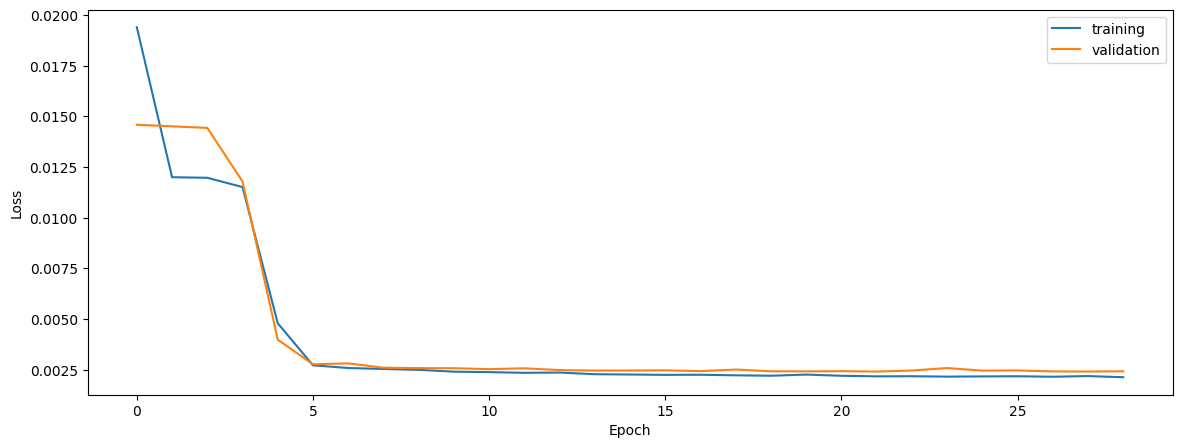

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9067779507395614
0.9137463051377132
0.926253388136813


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.9067779507395614
0.9137463051377132
0.926253388136813


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.908320787800073
0.91589982364596
0.9352085088909792


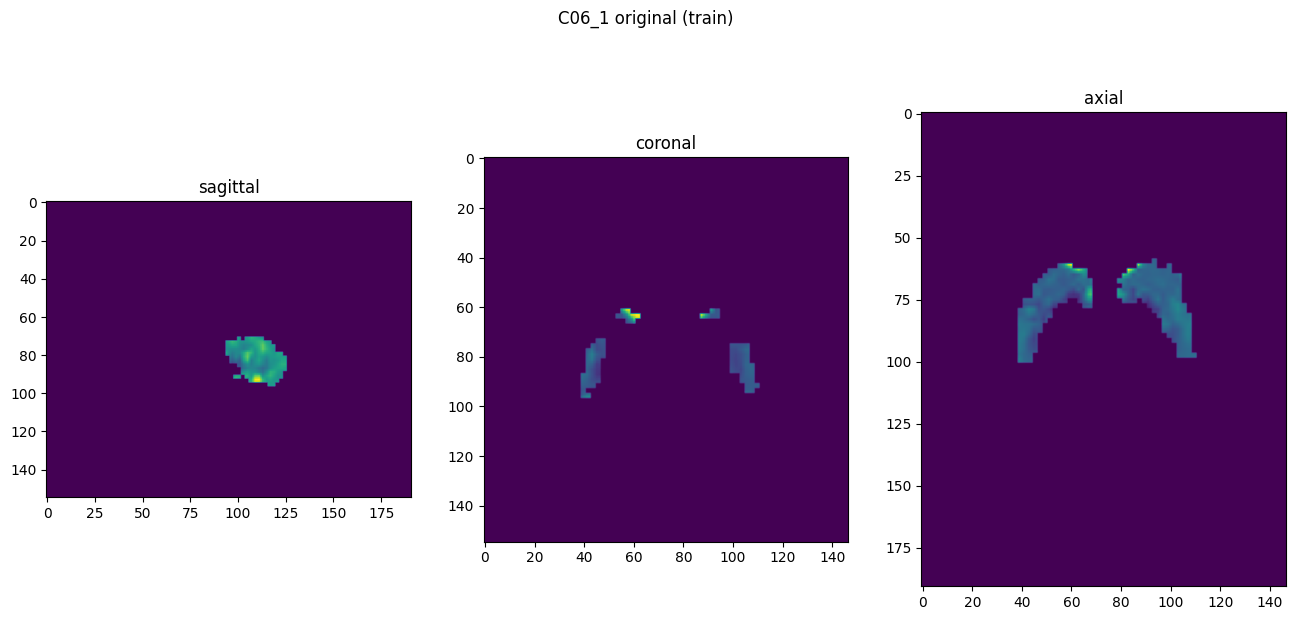

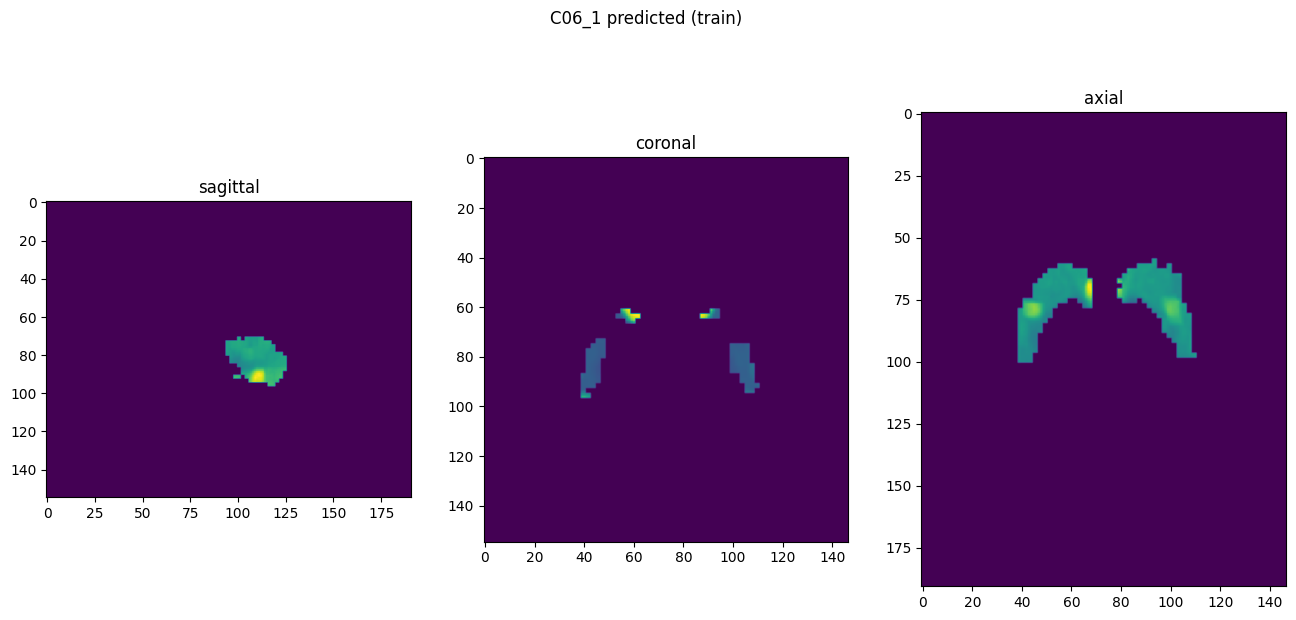

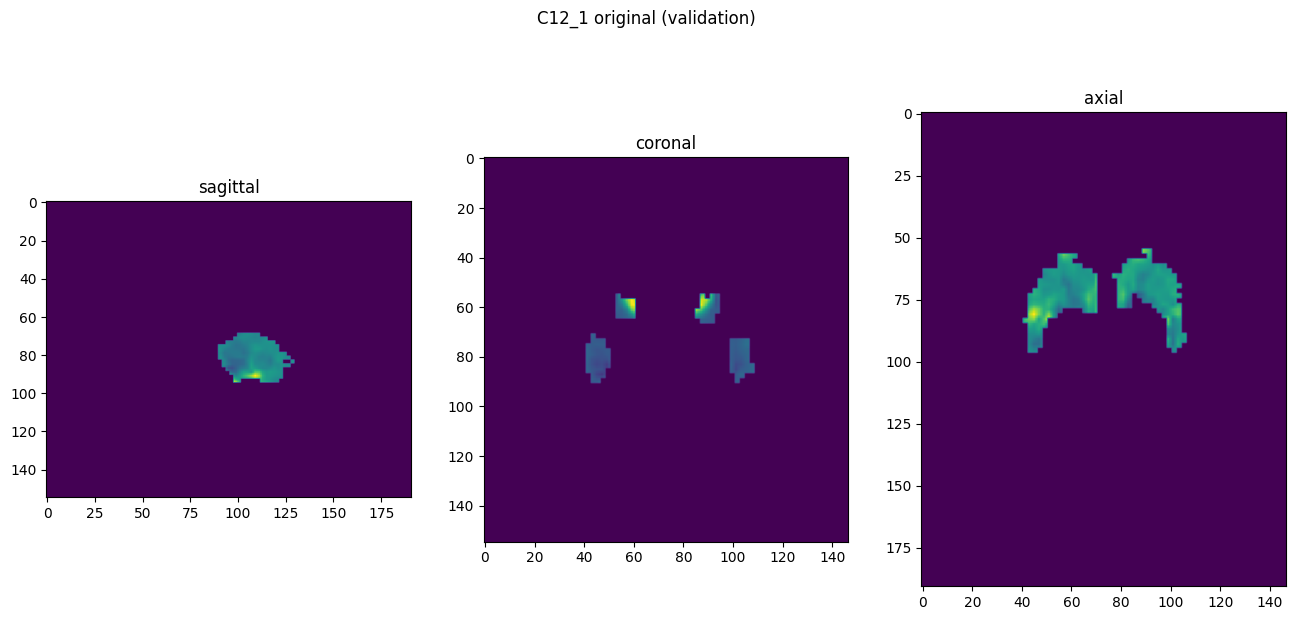

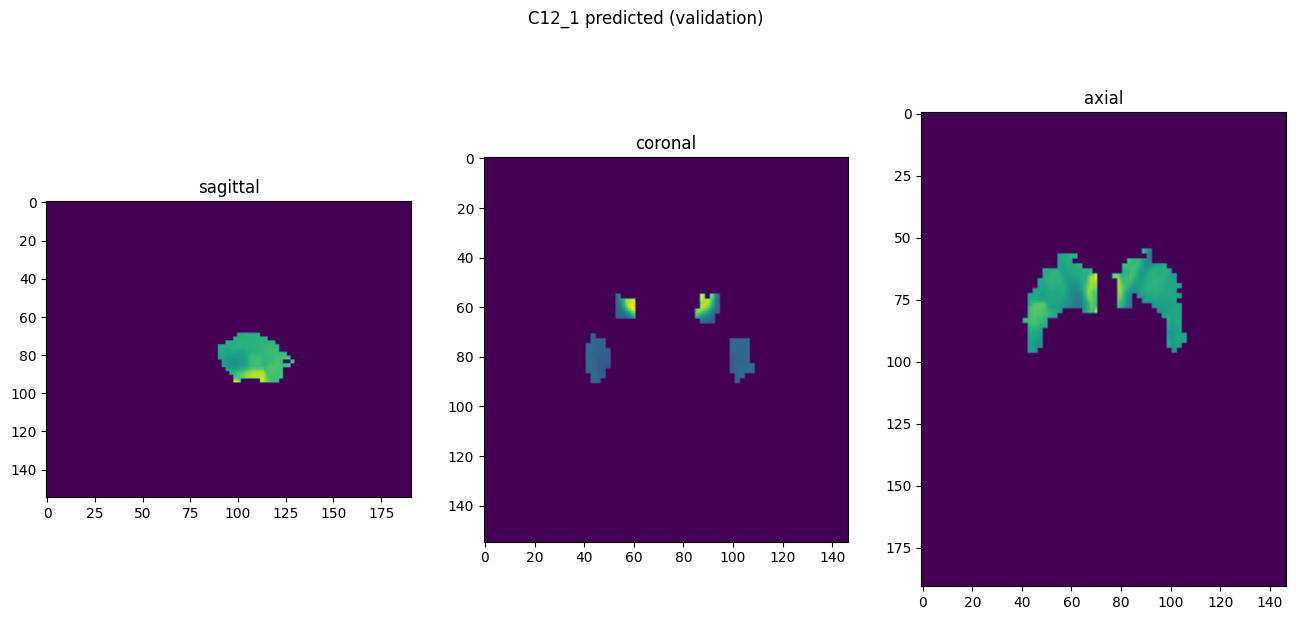

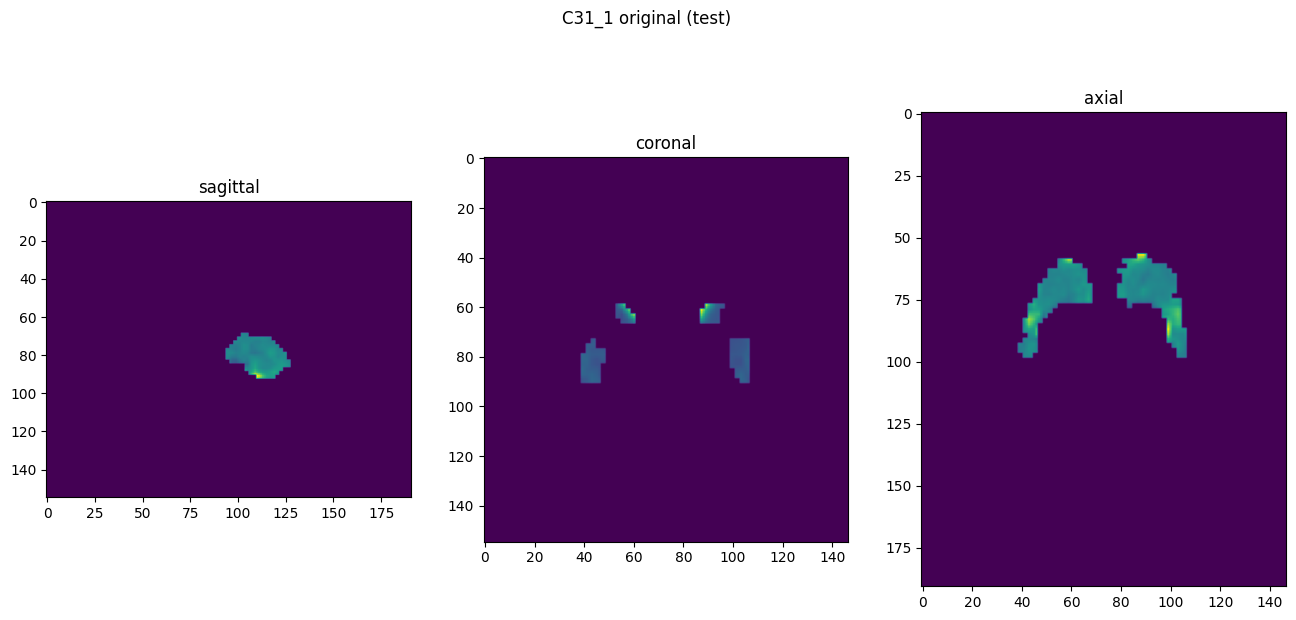

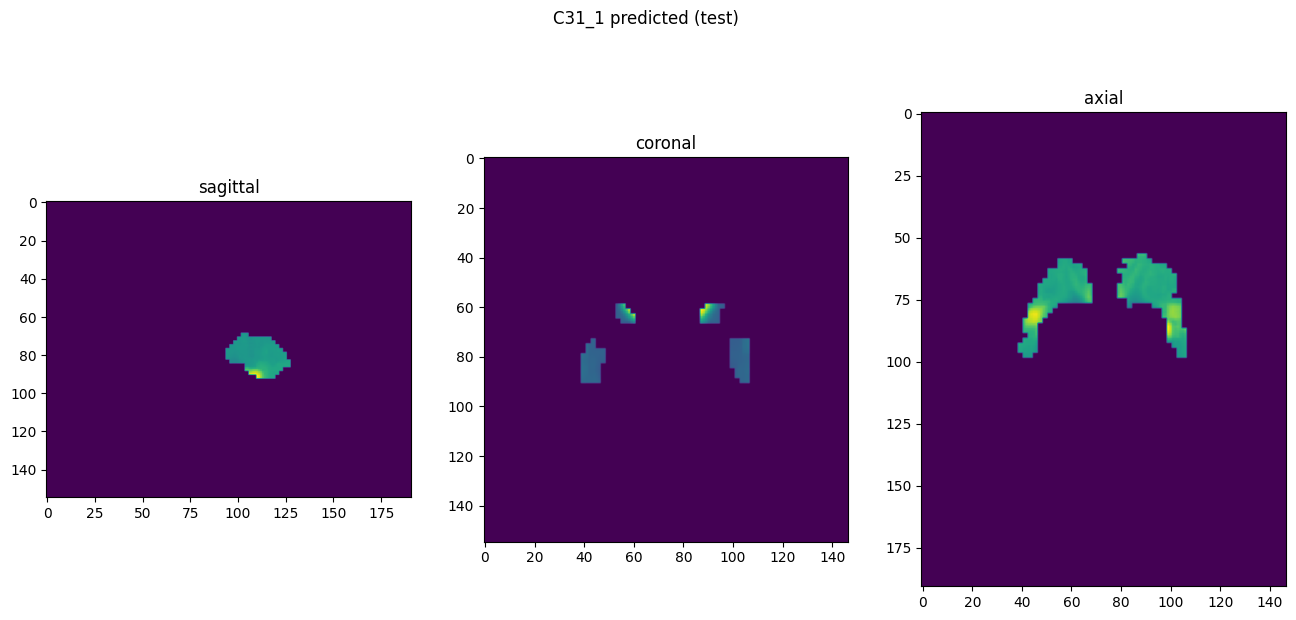

In [10]:
showResults(model, gen, threshold=None, background=False)